In [1]:
import pandas as pd
import xarray as xr
import numpy as np

import re
import datetime
import time

import os

import matplotlib.pyplot as plt
import matplotlib

In [5]:
re_date = re.compile(r"\D(\d{8})\D")

def WeekOffset(y):
    return {2020:0,2021:53,2022:52+53}[y]

def DateFrom8digitName(s):
    ds = re_date.findall(s)[0]
    y,m,d = map(int,(ds[:4],ds[4:6],ds[6:],))
    return datetime.datetime(y,m,d)

def RKI_AG_to_int(x):
    return int(x.replace("+","-").split("-")[0])

def ParseAltersgruppe(fn):
    df = pd.read_csv(fn,sep=";")
    df["Altersgruppe"] = df["Altersgruppe"].map(RKI_AG_to_int)
    f = {"Altersgruppe":"age","Geschlecht":"sex","Anzahl Fälle":"cases","Fälle vergangene 7 Tage":"cases7","verstorbene Fälle":"deaths"}
    df.rename(columns=f,inplace=True)
    df["sex"] = df["sex"].map(lambda x : {"m":"male","w":"female","d":"divers"}[x])
    df = df.filter(f.values()).set_index(["sex","age"])

    xr = df.to_xarray().fillna(0).astype("int64")
    return DateFrom8digitName(fn),xr
    

def ParseWocheAlter(fn):
    df = pd.read_csv(fn,sep=";")
    df["Altersgruppe"] = df["Altersgruppe"].map(RKI_AG_to_int)
    f = {"Altersgruppe":"age","Meldewoche":"week","Jahr":"year","Anzahl Fälle":"cases"}
    df.rename(columns=f,inplace=True)
    
    df["week"] = df["week"]+df["year"].map(WeekOffset)
    del df["year"]
    df = df.set_index(["week","age"])

    xr = df.to_xarray().fillna(0).astype("int64")
    return DateFrom8digitName(fn),xr

def ImportNDS(d="Data"):
    files = sorted(os.listdir(d))

    Altersgruppe = {}
    Woche = {}

    for fn in files[:]:
        if fn[:25] == "NDS_Covid19_Altersgruppe_":
            dt,x = ParseAltersgruppe(d+"/"+fn)
            Altersgruppe[dt] = x
        elif fn[:23] == "NDS_Covid19_Woche_Alter":
            dt,x = ParseWocheAlter(d+"/"+fn)
            Woche[dt] = x
        else:
            pass
    
    # concatenate xarrays by publication-date
    data = {"Altersgruppe":Altersgruppe,"Woche":Woche}
    for k,x in data.items():
        data[k] = xr.concat(x.values(),pd.Index(x.keys(),name="publication")).fillna(0).astype("int64")
    return data["Altersgruppe"],data["Woche"]
    
t0 = time.time()

Altersgruppe,Woche = ImportNDS("./")
        
t1 = time.time()
print("in %.3f"%(t1-t0))


print(Altersgruppe.nbytes/1024)
print(Woche.nbytes/1024)

print(Woche.coords)


in 0.556
21.4296875
115.5390625
Coordinates:
  * week         (week) int64 9 10 11 12 13 14 15 16 ... 50 51 52 53 54 55 56 57
  * age          (age) int64 0 10 20 30 40 50 60 70 80 90
  * publication  (publication) datetime64[ns] 2020-12-29 ... 2021-01-29


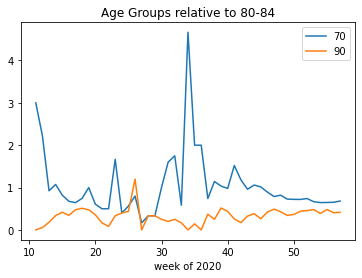

In [6]:
latest_cases = Woche.sel(publication=datetime.datetime(2021,1,29))["cases"]
cases_adj = latest_cases.sel(age=[70,90])
cases_80 = latest_cases.sel(age=80)


rel = cases_adj/cases_80



plt.plot(rel.get_index("week"),rel.transpose("week","age"))
plt.legend(rel.get_index("age").values)
plt.title("Age Groups relative to 80-84")
plt.xlabel("week of 2020")

plt.savefig("AgeGroupsRelativeTo80_byWeeks_NDS.svg")

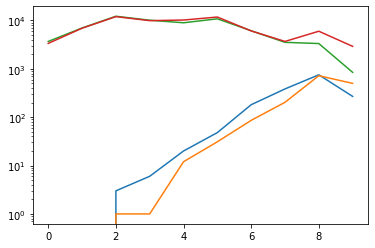

In [7]:
latest_deaths = Altersgruppe.sel(publication=datetime.datetime(2021,1,29))["deaths"].sel(sex=["male","female"])
plt.semilogy(latest_deaths.transpose("age","sex"))

latest_cases = Altersgruppe.sel(publication=datetime.datetime(2021,1,29))["cases"].sel(sex=["male","female"])
plt.semilogy(latest_cases.transpose("age","sex"))

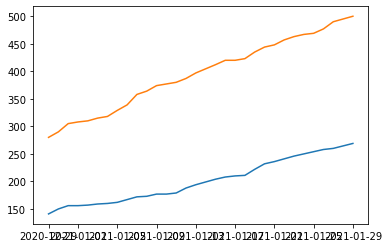

In [8]:
plt.plot(Altersgruppe.get_index("publication"),Altersgruppe["deaths"].sel(sex=["male","female"],age=90).transpose("publication","sex"))